## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [ ]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)
import ipywidgets as ipyw

## Visualizing the distribution of the observations

## Load the required libraries

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [ ]:
sc.stop()

In [4]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [5]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [47]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBSSSB'
meas='TOBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
1186
+------------------+------------------+------------------+---------+--------+--------+---------+-----------+------------------+--------------------+--------------------+------------------+-----------+-----------+------+--------------------+------+
|           coeff_1|           coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|               res_2|               res_3|          res_mean|    station|  total_var|undefs|              vector|  year|
+------------------+------------------+------------------+---------+--------+--------+---------+-----------+------------------+--------------------+--------------------+------------------+-----------+-----------+------+--------------------+------+
|3170.2660561990124|-244.6928970996399|180.35852466852654|      8.5|SSSBSSSB| 38.0167|-121.7667|       TOBS|0.0528546292095103|0.048992442664216575| 0.04948416401780212|0.8522288474

In [48]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+------------------+
|    station|latitude|longitude|elevation|           coeff_1|
+-----------+--------+---------+---------+------------------+
|USC00040227| 38.0167|-121.7667|      8.5|3170.2660561990124|
|USC00043244| 37.5422|-122.0158|     11.6|3108.0411935130724|
|USC00040227| 38.0167|-121.7667|      8.5| 2565.349424504142|
|USC00047864| 37.5333|   -122.3|      6.1| 3029.872612038221|
+-----------+--------+---------+---------+------------------+
only showing top 4 rows



In [49]:
q="SELECT * FROM weather where 1=2"
print(q)
temp = sqlContext.sql(q)
temp.show(4)

SELECT * FROM weather where 1=2
+-------+-------+-------+---------+-----+--------+---------+-----------+-----+-----+-----+--------+-------+---------+------+------+----+
|coeff_1|coeff_2|coeff_3|elevation|label|latitude|longitude|measurement|res_1|res_2|res_3|res_mean|station|total_var|undefs|vector|year|
+-------+-------+-------+---------+-----+--------+---------+-----------+-----+-----+-----+--------+-------+---------+------+------+----+
+-------+-------+-------+---------+-----+--------+---------+-----------+-----+-----+-----+--------+-------+---------+------+------+----+



In [50]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
23,USC00040227,38.0167,-121.7667,8.5,30,3033.352288
33,USC00040232,37.9856,-121.7458,18.3,44,2444.520074


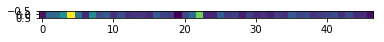

In [12]:
a = pdf.loc[:,'avg(coeff_1)'].tolist()
a = np.matrix(a)
plt.imshow(a)
plt.show()

In [ ]:
a

In [53]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(2000)

u'#0018ff'

## Map

In [54]:
min_lat,max_lat,min_long,max_long = box = (37.4833, 38.2103, -123.0, -120.867)


In [55]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 8

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
foo = []
coeff_list = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    coeff_list.append(_coef)
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(1800*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    foo.append((_coef,get_color(_coef)))
    circles.append(c)
    m.add_layer(c)

m    

In [42]:
sorted(foo

[(-285.0949183458735, u'#0000bb'),
 (1139.1839210693972, u'#00d0ff'),
 (1242.0926329903618, u'#00e4f8'),
 (2046.092393582445, u'#80ff77'),
 (4598.653269789525, u'#800000'),
 (1352.164196433992, u'#0ff8e7'),
 (13.773910738376458, u'#0000ff'),
 (1896.866577529627, u'#66ff90'),
 (657.8147663210381, u'#0070ff'),
 (954.7868377963434, u'#00acff'),
 (180.80385202427837, u'#0010ff'),
 (678.6759545282389, u'#0074ff'),
 (160.16418879084947, u'#000cff'),
 (241.55865104269904, u'#001cff'),
 (253.31710787808723, u'#0020ff'),
 (52.97310168554576, u'#0000ff'),
 (900.1046729638351, u'#00a0ff'),
 (470.3785625472372, u'#004cff'),
 (424.3877494392482, u'#0040ff'),
 (-558.9021205427215, u'#000080'),
 (535.9980523296277, u'#0058ff'),
 (1259.7394504260621, u'#02e8f4'),
 (3509.440740802786, u'#ff7300'),
 (5.093555965260021, u'#0000fa'),
 (-20.793879999364226, u'#0000f6'),
 (990.554418637414, u'#00b0ff'),
 (358.6794972347664, u'#0034ff'),
 (446.9930781290191, u'#0044ff'),
 (-134.447583291915, u'#0000df'),
 (4

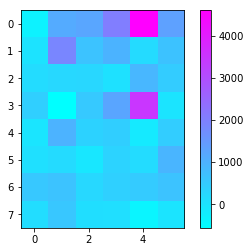

In [26]:


fig,ax = plt.subplots()
coeff_list = np.asarray(coeff_list)
coeff_list = np.reshape(coeff_list,(8,6))
cax = ax.imshow(coeff_list, cmap='cool', interpolation='nearest')
#cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
cbar = fig.colorbar(cax)
#cbar.ax.set_yticklabels(['-1', '0', '1'],minor = False)        
#plt.savefig("Activations/Activation_Neuron_"+str(i))
#plt.gcf().clear()
#plt.close()
plt.show()

In [40]:
sorted(coeff_list)

[-558.9021205427215,
 -341.82894494467,
 -285.0949183458735,
 -134.447583291915,
 -65.25671198676591,
 -20.793879999364226,
 5.093555965260021,
 13.773910738376458,
 52.97310168554576,
 81.35633247804272,
 93.6571541827671,
 106.24836129845922,
 134.17689528749258,
 160.16418879084947,
 163.60331881315108,
 179.46367878258133,
 180.80385202427837,
 240.47760368180724,
 241.55865104269904,
 253.31710787808723,
 336.7106608014727,
 358.6794972347664,
 392.42151198514256,
 424.3877494392482,
 446.9930781290191,
 455.7129396679224,
 470.3785625472372,
 504.05441051946497,
 535.9980523296277,
 567.2403391458906,
 586.5277699957873,
 656.9192611531284,
 657.6181956135033,
 657.8147663210381,
 678.6759545282389,
 900.1046729638351,
 950.3776251650911,
 954.7868377963434,
 990.554418637414,
 1139.1839210693972,
 1242.0926329903618,
 1259.7394504260621,
 1352.164196433992,
 1896.866577529627,
 2046.092393582445,
 3509.440740802786,
 4598.653269789525]

In [20]:
len(coeff_list)

47

In [43]:
sorted(foo)

[(-558.9021205427215, u'#000080'),
 (-341.82894494467, u'#0000ad'),
 (-285.0949183458735, u'#0000bb'),
 (-134.447583291915, u'#0000df'),
 (-65.25671198676591, u'#0000ed'),
 (-20.793879999364226, u'#0000f6'),
 (5.093555965260021, u'#0000fa'),
 (13.773910738376458, u'#0000ff'),
 (52.97310168554576, u'#0000ff'),
 (81.35633247804272, u'#0000ff'),
 (93.6571541827671, u'#0000ff'),
 (106.24836129845922, u'#0004ff'),
 (134.17689528749258, u'#0008ff'),
 (160.16418879084947, u'#000cff'),
 (163.60331881315108, u'#000cff'),
 (179.46367878258133, u'#0010ff'),
 (180.80385202427837, u'#0010ff'),
 (240.47760368180724, u'#001cff'),
 (241.55865104269904, u'#001cff'),
 (253.31710787808723, u'#0020ff'),
 (336.7106608014727, u'#0030ff'),
 (358.6794972347664, u'#0034ff'),
 (392.42151198514256, u'#003cff'),
 (424.3877494392482, u'#0040ff'),
 (446.9930781290191, u'#0044ff'),
 (455.7129396679224, u'#0048ff'),
 (470.3785625472372, u'#004cff'),
 (504.05441051946497, u'#0050ff'),
 (535.9980523296277, u'#0058ff'),

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

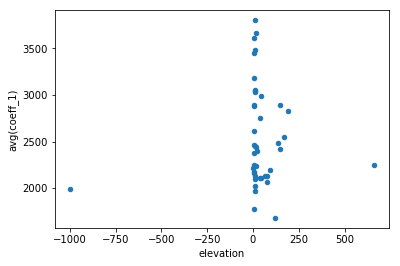

In [51]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

In [ ]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()